## **如何理解Wide部分有利于增强模型的“记忆能力”，Deep部分有利于增强模型的“泛化能力”？**

- wide部分是一个广义的线性模型，输入的特征主要有两部分组成，一部分是原始的部分特征，另一部分是原始特征的交叉特征(cross-product transformation)，对于交互特征可以定义为：
  $$
  \phi_{k}(x)=\prod_{i=1}^d x_i^{c_{ki}}, c_{ki}\in \{0,1\}
  $$
  $c_{ki}$是一个布尔变量，当第i个特征属于第k个特征组合时，$c_{ki}$的值为1，否则为0，$x_i$是第i个特征的值，大体意思就是两个特征都同时为1这个新的特征才能为1，否则就是0，说白了就是一个特征组合。用原论文的例子举例：

  > AND(user_installed_app=QQ, impression_app=WeChat)，当特征user_installed_app=QQ,和特征impression_app=WeChat取值都为1的时候，组合特征AND(user_installed_app=QQ, impression_app=WeChat)的取值才为1，否则为0。
  
  对于wide部分训练时候使用的优化器是带$L_1$正则的FTRL算法(Follow-the-regularized-leader)，而L1 FTLR是非常注重模型稀疏性质的，也就是说W&D模型采用L1 FTRL是想让Wide部分变得更加的稀疏，即Wide部分的大部分参数都为0，这就大大压缩了模型权重及特征向量的维度。**Wide部分模型训练完之后留下来的特征都是非常重要的，那么模型的“记忆能力”就可以理解为发现"直接的"，“暴力的”，“显然的”关联规则的能力。**例如Google W&D期望wide部分发现这样的规则：**用户安装了应用A，此时曝光应用B，用户安装应用B的概率大。**
  
- Deep部分是一个DNN模型，输入的特征主要分为两大类，一类是数值特征(可直接输入DNN)，一类是类别特征(需要经过Embedding之后才能输入到DNN中)，Deep部分的数学形式如下：
  $$
  a^{(l+1)} = f(W^{l}a^{(l)} + b^{l})
  $$
  **我们知道DNN模型随着层数的增加，中间的特征就越抽象，也就提高了模型的泛化能力。**对于Deep部分的DNN模型作者使用了深度学习常用的优化器AdaGrad，这也是为了使得模型可以得到更精确的解。

#### 在wide部分加入了所有可能的一阶特征，包括数值特征和类别特征的onehot都加进去了，其实也可以加入一些与wide&deep原论文中类似交叉特征。只要能够发现高频、常见模式的特征都可以放在wide侧，对于Deep部分，在本数据中放入了数值特征和类别特征的embedding特征，实际应用也需要根据需求进行选择。


In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import namedtuple

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder

from utils import SparseFeat, DenseFeat, VarLenSparseFeat

In [2]:
# 简单处理特征，包括填充缺失值，数值处理，类别编码
def data_process(data_df, dense_features, sparse_features):
    data_df[dense_features] = data_df[dense_features].fillna(0.0)
    for f in dense_features:
        data_df[f] = data_df[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
        
    data_df[sparse_features] = data_df[sparse_features].fillna("-1")
    for f in sparse_features:
        lbe = LabelEncoder()
        data_df[f] = lbe.fit_transform(data_df[f])
    
    return data_df[dense_features + sparse_features]


def build_input_layers(feature_columns):
    # 构建Input层字典，并以dense和sparse两类字典的形式返回
    dense_input_dict, sparse_input_dict = {}, {}

    for fc in feature_columns:
        if isinstance(fc, SparseFeat):
            sparse_input_dict[fc.name] = Input(shape=(1, ), name=fc.name)
        elif isinstance(fc, DenseFeat):
            dense_input_dict[fc.name] = Input(shape=(fc.dimension, ), name=fc.name)
        
    return dense_input_dict, sparse_input_dict


def build_embedding_layers(feature_columns, input_layers_dict, is_linear):
    # 定义一个embedding层对应的字典
    embedding_layers_dict = dict()
    
    # 将特征中的sparse特征筛选出来
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if feature_columns else []
    
    # 如果是用于线性部分的embedding层，其维度为1，否则维度就是自己定义的embedding维度
    if is_linear:
        for fc in sparse_feature_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size, 1, name='1d_emb_' + fc.name)
    else:
        for fc in sparse_feature_columns:
            embedding_layers_dict[fc.name] = Embedding(fc.vocabulary_size, fc.embedding_dim, name='kd_emb_' + fc.name)
    
    return embedding_layers_dict

In [3]:
def get_linear_logits(dense_input_dict, sparse_input_dict, sparse_feature_columns):
    # 将所有的dense特征的Input层，然后经过一个全连接层得到dense特征的logits
    concat_dense_inputs = Concatenate(axis=1)(list(dense_input_dict.values()))
    dense_logits_output = Dense(1)(concat_dense_inputs)
    
    # 获取linear部分sparse特征的embedding层，这里使用embedding的原因是：
    # 对于linear部分直接将特征进行onehot然后通过一个全连接层，当维度特别大的时候，计算比较慢
    # 使用embedding层的好处就是可以通过查表的方式获取到哪些非零的元素对应的权重，然后在将这些权重相加，效率比较高
    linear_embedding_layers = build_embedding_layers(sparse_feature_columns, sparse_input_dict, is_linear=True)
    
    # 将一维的embedding拼接，注意这里需要使用一个Flatten层，使维度对应
    sparse_1d_embed = []
    for fc in sparse_feature_columns:
        feat_input = sparse_input_dict[fc.name]
        embed = Flatten()(linear_embedding_layers[fc.name](feat_input)) # B x 1
        sparse_1d_embed.append(embed)

    # embedding中查询得到的权重就是对应onehot向量中一个位置的权重，所以后面不用再接一个全连接了，本身一维的embedding就相当于全连接
    # 只不过是这里的输入特征只有0和1，所以直接向非零元素对应的权重相加就等同于进行了全连接操作(非零元素部分乘的是1)
    sparse_logits_output = Add()(sparse_1d_embed)

    # 最终将dense特征和sparse特征对应的logits相加，得到最终linear的logits
    linear_logits = Add()([dense_logits_output, sparse_logits_output])
    return linear_logits


# 将所有的sparse特征embedding拼接
def concat_embedding_list(feature_columns, input_layer_dict, embedding_layer_dict, flatten=False):
    # 将sparse特征筛选出来
    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns))

    embedding_list = []
    for fc in sparse_feature_columns:
        _input = input_layer_dict[fc.name] # 获取输入层 
        _embed = embedding_layer_dict[fc.name] # B x 1 x dim  获取对应的embedding层
        embed = _embed(_input) # B x dim  将input层输入到embedding层中

        # 是否需要flatten, 如果embedding列表最终是直接输入到Dense层中，需要进行Flatten，否则不需要
        if flatten:
            embed = Flatten()(embed)
        
        embedding_list.append(embed)
    
    return embedding_list 


def get_dnn_logits(dense_input_dict, sparse_input_dict, sparse_feature_columns, dnn_embedding_layers):
    concat_dense_inputs = Concatenate(axis=1)(list(dense_input_dict.values())) # B x n1 (n表示的是dense特征的维度) 

    sparse_kd_embed = concat_embedding_list(sparse_feature_columns, sparse_input_dict, dnn_embedding_layers, flatten=True)

    concat_sparse_kd_embed = Concatenate(axis=1)(sparse_kd_embed) # B x n2k  (n2表示的是Sparse特征的维度)

    dnn_input = Concatenate(axis=1)([concat_dense_inputs, concat_sparse_kd_embed]) # B x (n2k + n1)

    # dnn层，这里的Dropout参数，Dense中的参数及Dense的层数都可以自己设定
    dnn_out = Dropout(0.5)(Dense(1024, activation='relu')(dnn_input))  
    dnn_out = Dropout(0.3)(Dense(512, activation='relu')(dnn_out))
    dnn_out = Dropout(0.1)(Dense(256, activation='relu')(dnn_out))

    dnn_logits = Dense(1)(dnn_out)

    return dnn_logits

In [4]:
# Wide&Deep 模型的wide部分及Deep部分的特征选择，应该根据实际的业务场景去确定哪些特征应该放在Wide部分，哪些特征应该放在Deep部分
def WideNDeep(linear_feature_columns, dnn_feature_columns):
    # 构建输入层，即所有特征对应的Input()层，这里使用字典的形式返回，方便后续构建模型
    dense_input_dict, sparse_input_dict = build_input_layers(linear_feature_columns + dnn_feature_columns)

    # 将linear部分的特征中sparse特征筛选出来，后面用来做1维的embedding
    linear_sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), linear_feature_columns))

    # 构建模型的输入层，模型的输入层不能是字典的形式，应该将字典的形式转换成列表的形式
    # 注意：这里实际的输入与Input()层的对应，是通过模型输入时候的字典数据的key与对应name的Input层
    input_layers = list(dense_input_dict.values()) + list(sparse_input_dict.values())

    # Wide&Deep模型论文中Wide部分使用的特征比较简单，并且得到的特征非常的稀疏，所以使用了FTRL优化Wide部分（这里没有实现FTRL）
    # 但是是根据他们业务进行选择的，我们这里将所有可能用到的特征都输入到Wide部分，具体的细节可以根据需求进行修改
    linear_logits = get_linear_logits(dense_input_dict, sparse_input_dict, linear_sparse_feature_columns)
    
    # 构建维度为k的embedding层，这里使用字典的形式返回，方便后面搭建模型
    embedding_layers = build_embedding_layers(dnn_feature_columns, sparse_input_dict, is_linear=False)

    dnn_sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), dnn_feature_columns))

    # 在Wide&Deep模型中，deep部分的输入是将dense特征和embedding特征拼在一起输入到dnn中
    dnn_logits = get_dnn_logits(dense_input_dict, sparse_input_dict, dnn_sparse_feature_columns, embedding_layers)
    
    # 将linear,dnn的logits相加作为最终的logits
    output_logits = Add()([linear_logits, dnn_logits])

    # 这里的激活函数使用sigmoid
    output_layer = Activation("sigmoid")(output_logits)

    model = Model(input_layers, output_layer)
    return model

In [5]:
# 读取数据
data = pd.read_csv('./data/criteo_sample.txt')

# 划分dense和sparse特征
columns = data.columns.values
dense_features = [feat for feat in columns if 'I' in feat]
sparse_features = [feat for feat in columns if 'C' in feat]

# 简单的数据预处理
train_data = data_process(data, dense_features, sparse_features)
train_data['label'] = data['label']

# 将特征分组，分成linear部分和dnn部分(根据实际场景进行选择)，并将分组之后的特征做标记（使用DenseFeat, SparseFeat）
linear_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                        for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                        for feat in dense_features]

dnn_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                        for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                        for feat in dense_features]

# 构建WideNDeep模型
history = WideNDeep(linear_feature_columns, dnn_feature_columns)
#history.summary()
history.compile(optimizer="adam", 
            loss="binary_crossentropy", 
            metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

# 将输入数据转化成字典的形式输入
train_model_input = {name: data[name] for name in dense_features + sparse_features}
# 模型训练
history.fit(train_model_input, train_data['label'].values,
        batch_size=64, epochs=7, validation_split=0.2, )    

Train on 160 samples, validate on 40 samples
Epoch 1/7
160/160 [==============================] - 7s 41ms/sample - loss: 1.3700 - binary_crossentropy: 1.3700 - auc: 0.3891 - val_loss: 1.4351 - val_binary_crossentropy: 1.4351 - val_auc: 0.4174
Epoch 2/7
160/160 [==============================] - 0s 448us/sample - loss: 1.0780 - binary_crossentropy: 1.0780 - auc: 0.4432 - val_loss: 1.0658 - val_binary_crossentropy: 1.0658 - val_auc: 0.4444
Epoch 3/7
160/160 [==============================] - 0s 451us/sample - loss: 0.8887 - binary_crossentropy: 0.8887 - auc: 0.4288 - val_loss: 0.8340 - val_binary_crossentropy: 0.8340 - val_auc: 0.5328
Epoch 4/7
160/160 [==============================] - 0s 444us/sample - loss: 0.7388 - binary_crossentropy: 0.7388 - auc: 0.5077 - val_loss: 0.7280 - val_binary_crossentropy: 0.7280 - val_auc: 0.6524
Epoch 5/7
160/160 [==============================] - 0s 443us/sample - loss: 0.5298 - binary_crossentropy: 0.5298 - auc: 0.7056 - val_loss: 0.6435 - val_binary_

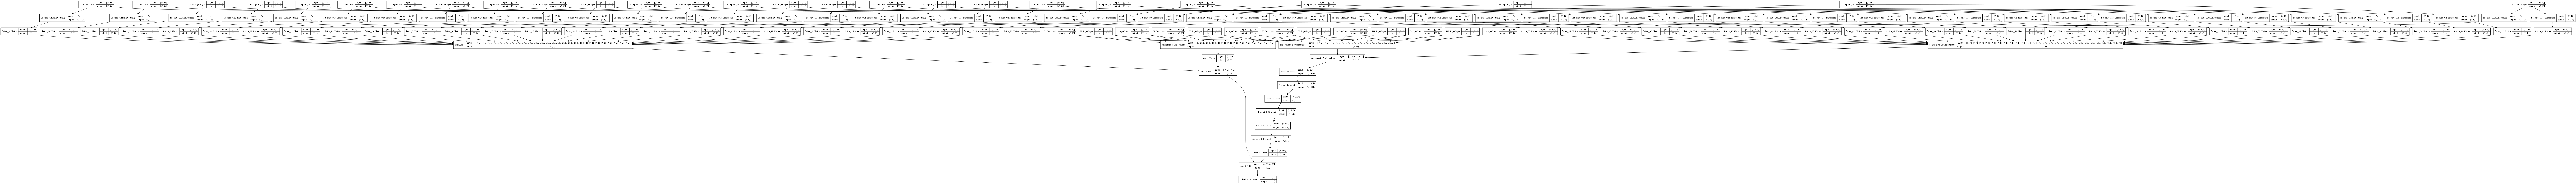

In [6]:
from tensorflow.keras.utils import  plot_model
plot_model(history,  show_shapes=True)